In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
%matplotlib inline

In [2]:
def K(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [4]:
def Ay(k,g,alpha,beta,sigma_c, sigma_h,x,n = 1000):
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

In [5]:
sigma_h = 1# RF size of horizontal cell
sigma_c = sigma_h*1/3# RF size of cone cell
gamma = 1/(sigma_c**2)
klen = 2*sigma_h# half of width of horizontal kernal
dx = 0.01*sigma_h
##Create spatial kernal
klen = sigma_h*3
xx = np.arange(-klen,klen,dx)

KC = K(xx,sigma_c)
KH = K(xx,sigma_h)
KKK = K(xx, dx*20) 

In [6]:
#Width setting
xlen = 10*sigma_h #spatial extend of simulation
hw = 0.75*sigma_h#half bar width
tempx = np.arange(0,xlen,dx)

In [7]:
dt = 0.01
alpha = 1/0.024
beta = 1./1.
k = alpha*0.3
phi = 1.
g = beta

g*k*phi/alpha/beta

0.3

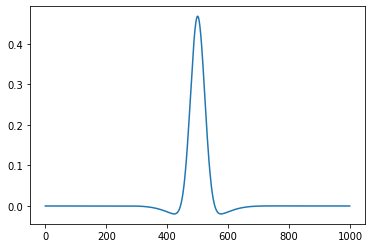

In [8]:
x = np.arange(-int(xlen/dx/2),int(xlen/dx/2))*dx
plt.plot(Ay(k,g,alpha,beta,sigma_c, sigma_h,x))

Whole Field STA

In [9]:
nstep = 5000

y = np.zeros(int(xlen/dx)) # cone cell output
z = np.zeros(int(xlen/dx)) # horizontal cell output
ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)



stm = np.zeros([int(xlen/dx),nstep])#input
rsp = np.zeros([int(xlen/dx),nstep])#y output
zts = np.zeros([int(xlen/dx),nstep])#horizontal

x = np.random.randn(nstep+99)*0.3+1
T = np.arange(100)*dt
tau_y = 0.02
Ky=T/tau_y/tau_y*np.exp(-T/tau_y)
sx = np.convolve(x,Ky,'valid')*dt

for i in range(nstep):
    s = np.ones(int(xlen/dx))*sx[i]
    rs = np.convolve(s,KC,'same')*dx
    
    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
    y = (y+dyj)
    z = (z+dzj)

    ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

    stm[:,i] = s
    rsp[:,i] = y
    zts[:,i] = z
    

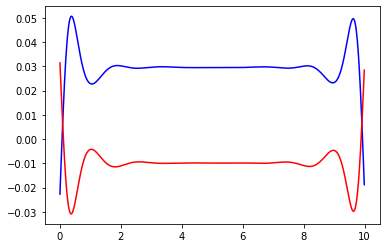

In [10]:
#####PLot numerical solution########
plt.plot(tempx,y,'b')#numerical solution
plt.plot(tempx,-z,'r')#numerical solution

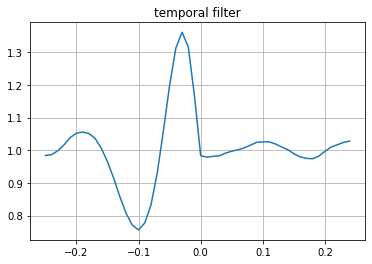

In [11]:
output = rsp[int(xlen/dx/2),:]
time, xSTA = STA(output, x[99:], dt, [-0.25,0.25])
plt.plot(time, xSTA)
plt.title('temporal filter')
plt.grid()

Checker spatial-temprol noise

In [12]:
nstep = 500000

y = np.zeros(int(xlen/dx)) # cone cell output
z = np.zeros(int(xlen/dx)) # horizontal cell output
ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

stm = np.zeros([int(xlen/dx),nstep])#input
sstm = np.zeros([int(xlen/dx),nstep])#smoothed input
rsp = np.zeros([int(xlen/dx),nstep])#y output
zts = np.zeros([int(xlen/dx),nstep])#horizontal


for j in range(0, int(xlen/dx)):
    x = np.random.randn(nstep+99)*0.3+1
    T = np.arange(100)*dt
    tau_y = 0.02
    Ky=T/tau_y/tau_y*np.exp(-T/tau_y)
    sx = np.convolve(x,Ky,'valid')*dt
    stm[j,:] = x[99:].copy()
    sstm[j,:] = sx.copy()

for i in range(nstep):
    s = sstm[:,i]
    rs = np.convolve(s,KC,'same')*dx
    
    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
    y = (y+dyj)
    z = (z+dzj)

    ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)
    
    rsp[:,i] = y
    zts[:,i] = z

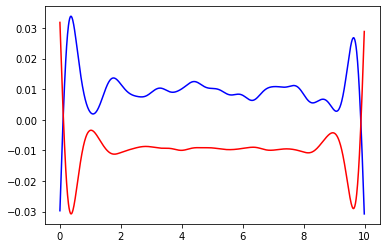

In [13]:
#####PLot numerical solution########
plt.plot(tempx,y,'b')#numerical solution
plt.plot(tempx,-z,'r')#numerical solution

In [27]:
output = rsp[int(xlen/dx/2),:]
time, xSTA = STA(output, stm[0,:], dt, [-0.25,0.25])
test = xSTA[:, np.newaxis]
for j in range(1, int(xlen/dx)):
    _, xSTA = STA(output, stm[j,:], dt, [-0.25,0.25])
    test = np.concatenate((test, xSTA[:, np.newaxis]), axis=1)

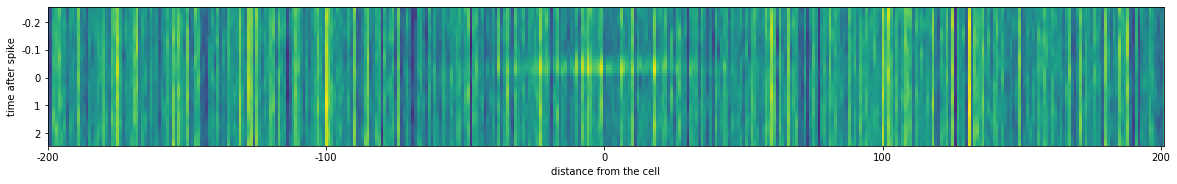

In [28]:
fig, ax = plt.subplots(1,1)
ax.imshow(test)
ax.set_ylabel('time after spike')
ax.set_yticks(np.arange(5,50,10))
ax.set_yticklabels(['-0.2','-0.1','0','1','2'])
ax.set_xticks(np.arange(300,701,100))
ax.set_xticklabels(['-200','-100','0','100','200'])
ax.set_xlabel('distance from the cell')
ax.set_xlim([300, 701])
fig.set_size_inches(20, 5)

choose center cell and a certain time before spike

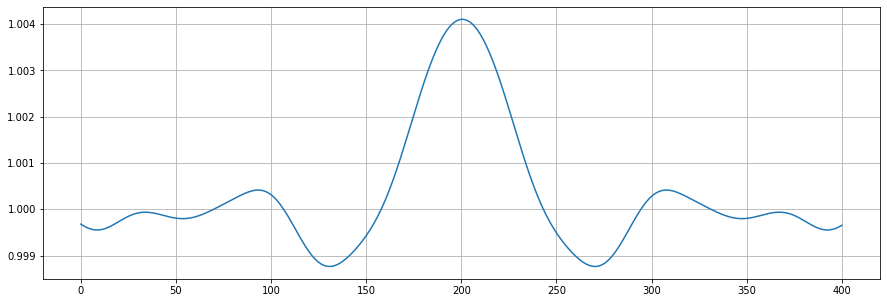

In [38]:
tbs_i = 20
plt.plot(np.convolve((test[tbs_i, :]+np.flip(test[tbs_i, :]))/2,KKK,'valid')*dx)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [71]:
ST_kernel = []
for i in range(int(np.shape(test)[0]/2)):
    ST_kernel.append(np.convolve((test[i, :]+np.flip(test[i, :]))/2,KKK,'valid')*dx)
ST_kernel = np.array(ST_kernel)
ST_kernel = np.flipud(ST_kernel)-1

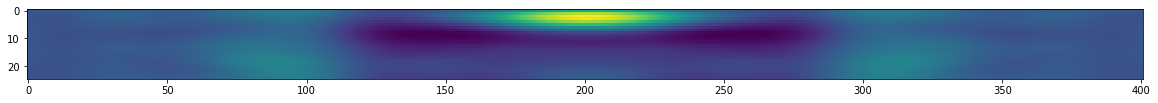

In [72]:
plt.imshow(ST_kernel)
fig = plt.gcf()
fig.set_size_inches(20, 5)

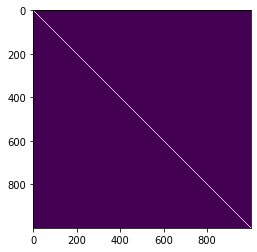

In [73]:
nstep = 1000
moving_bar = np.zeros([nstep, int(xlen/dx)])
pos = 0
v = 1 #dx/step
hw = 2 #dx
for i in range(nstep):
    pos = pos+v
    moving_bar[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
plt.imshow(moving_bar)

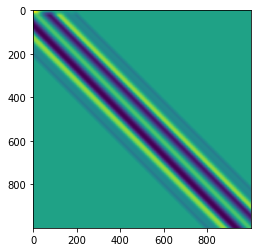

In [80]:
mb_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in range(i):
        if (i-ii) < np.shape(ST_kernel)[0]:
            mb_y[i,:] += np.convolve(moving_bar[ii,:],ST_kernel[i-ii, :], 'same')*dt
plt.imshow(mb_y)

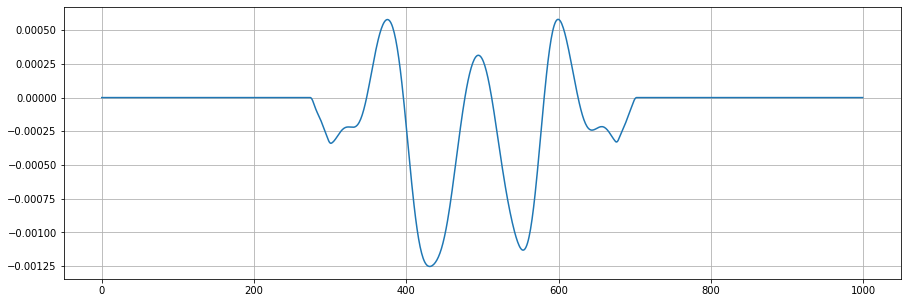

In [81]:
plt.plot(mb_y[500,:])
# plt.plot(moving_bar[500,:])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)